# GAN Implementation for Number Image Generator

## Setup

In [1]:
import torch
print(torch.__version__)
import glob
import imageio  # pip install imageio to generate GIFs
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image  # PIL is the same in PyTorch as in TensorFlow
import time

from IPython import display


2.4.0


## Loading and Preparing the Dataset

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales [0, 255] to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader for batching and shuffling
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


## Creating the Model

### The Generator

In [3]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Determine the device (GPU if available, otherwise CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = nn.Sequential(
            # Input layer: Fully connected layer
            nn.Linear(100, 7 * 7 * 256, bias=False),
            nn.BatchNorm1d(7 * 7 * 256),
            nn.LeakyReLU(0.2, inplace=False),  # Ensure inplace=False

            # Reshape output to (256, 7, 7)
            nn.Unflatten(1, (256, 7, 7)),

            # First transposed convolutional layer
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128, eps=1e-5),
            nn.LeakyReLU(0.2, inplace=False),  # Ensure inplace=False

            # Second transposed convolutional layer
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-5),
            nn.LeakyReLU(0.2, inplace=False),  # Ensure inplace=False

            # Third transposed convolutional layer (output layer)
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

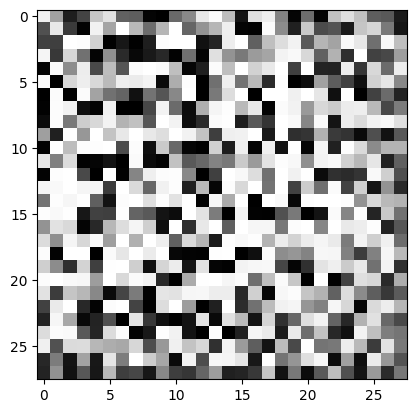

In [4]:
import torch

# Create the generator
generator = Generator()

# Generate random noise as input for the generator
noise = torch.randn(16, 100)  # Generate a batch of 16 noise samples

# Generate the image from the noise
with torch.no_grad():  # Disable gradient tracking since we're not training
    generated_images = generator(noise)

# Select the first generated image and reshape it to (28, 28)
generated_image = generated_images[0].view(28, 28).cpu().numpy()

# Plot the generated image
plt.imshow(generated_image, cmap='gray')
plt.show()



### The Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=False),  # Ensure inplace=False
            # nn.Dropout(0.3),

            # Second convolutional layer
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=False),  # Ensure inplace=False
            # nn.Dropout(0.3),

            # Flatten layer
            nn.Flatten(),

            # Output layer
            nn.Linear(128 * 7 * 7, 1)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
import torch

# Create an instance of the Discriminator
discriminator = Discriminator()

# Move the discriminator to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator = discriminator.to(device)

# Convert generated_image to a PyTorch tensor, move to the device, and adjust dimensions if necessary
generated_image_tensor = torch.tensor(generated_image, dtype=torch.float32).to(device)

# If the tensor has a shape of (H, W, C), reorder to (C, H, W) and add batch dimension
if len(generated_image_tensor.shape) == 3:  # (H, W, C)
    generated_image_tensor = generated_image_tensor.permute(2, 0, 1).unsqueeze(0)  # Shape: (1, C, H, W)
elif len(generated_image_tensor.shape) == 2:  # (H, W), for grayscale images
    generated_image_tensor = generated_image_tensor.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

# Pass the generated image tensor through the discriminator
decision = discriminator(generated_image_tensor)

# Print the output
print(decision)


tensor([[-0.0251]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Defining the Loss and Optimizers

In [7]:
import torch.nn as nn

# Define the cross entropy loss (Binary Cross Entropy with logits)
cross_entropy = nn.BCEWithLogitsLoss()


### Discriminator Loss

In [8]:
def discriminator_loss(real_output, fake_output):
    # Loss for real images
    real_labels = torch.ones_like(real_output)  # Labels for real images
    real_loss = cross_entropy(real_output, real_labels)

    # Loss for fake images
    fake_labels = torch.zeros_like(fake_output)  # Labels for fake images
    fake_loss = cross_entropy(fake_output, fake_labels)

    # Total loss
    total_loss = real_loss + fake_loss
    return total_loss


### Generator Loss

In [9]:
def generator_loss(fake_output):
    # Labels for fake images (should be classified as real by the generator)
    target_labels = torch.ones_like(fake_output)
    
    # Calculate the generator loss
    loss = cross_entropy(fake_output, target_labels)
    return loss


In [10]:
import torch.optim as optim

# Set up optimizers for the generator and discriminator
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)


In [11]:
import os

# Directory for saving checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save a checkpoint
def save_checkpoint(generator, discriminator, generator_optimizer, discriminator_optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'ckpt_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_optimizer_state_dict': generator_optimizer.state_dict(),
        'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
    }, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')

# Function to load a checkpoint
def load_checkpoint(generator, discriminator, generator_optimizer, discriminator_optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f'Checkpoint loaded from {checkpoint_path}, starting at epoch {epoch}')
    return epoch


## Defining the Training Loop

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Reuse this seed to visualize progress over time
seed = torch.randn(num_examples_to_generate, noise_dim)  # Shape: (batch_size, noise_dim)


In [13]:
def train_step(real_images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    # Get the device from one of the generator's parameters
    device = next(generator.parameters()).device

    # Move the real images to the appropriate device
    real_images = real_images.to(device)

    # Generate random noise for the generator
    noise = torch.randn(BATCH_SIZE, noise_dim, device=device)

    # Training mode for both generator and discriminator
    generator.train()
    discriminator.train()

    # Generate fake images
    generated_images = generator(noise)

    # ----- Discriminator Training -----
    real_output = discriminator(real_images)
    fake_output = discriminator(generated_images.detach())

    # Compute discriminator loss
    disc_loss = discriminator_loss(real_output, fake_output)

    # Zero gradients for discriminator optimizer
    discriminator_optimizer.zero_grad()

    # Backpropagate discriminator loss and update discriminator parameters
    disc_loss.backward()
    discriminator_optimizer.step()

    # ----- Generator Training -----
    fake_output = discriminator(generated_images)

    # Compute generator loss
    gen_loss = generator_loss(fake_output)

    # Zero gradients for generator optimizer
    generator_optimizer.zero_grad()

    # Backpropagate generator loss and update generator parameters
    gen_loss.backward()
    generator_optimizer.step()

    return gen_loss.item(), disc_loss.item()


In [14]:
def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, checkpoint_interval=15):
    # Determine the device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move models to the device
    generator.to(device)
    discriminator.to(device)

    for epoch in range(epochs):
        start = time.time()

        # Iterate through batches in the dataset
        for image_batch in dataset:
            # Move the batch to the device
            image_batch = image_batch[0].to(device)

            # Perform a training step
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer)

        # Clear output and display progress
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(generator, discriminator, generator_optimizer, discriminator_optimizer, epoch + 1)

        # Log time taken for the epoch
        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

    # Generate images after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)



In [15]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_input):
    # Determine the device from the model's parameters
    device = next(model.parameters()).device

    # Move the test input to the same device as the model
    test_input = test_input.to(device)

    # Generate predictions from the model
    with torch.no_grad():  # Disable gradient calculation
        predictions = model(test_input)

    # Reshape and move predictions back to CPU for plotting
    predictions = predictions.cpu().numpy()

    # Set up the plot
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Convert the pixel values back to [0, 255]
        plt.imshow(predictions[i, 0, :, :] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # Save the figure
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


## Train the Model

In [16]:
import os
import torch

def load_latest_checkpoint(checkpoint_dir, generator, discriminator, generator_optimizer, discriminator_optimizer):
    # Find all checkpoint files in the directory
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if not checkpoint_files:
        print("No checkpoint found.")
        return 0  # Start from epoch 0 if no checkpoint is available

    # Find the latest checkpoint by sorting the filenames
    latest_checkpoint = max(checkpoint_files, key=lambda f: int(f.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Restore the model and optimizer states
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    print(f"Checkpoint restored from {checkpoint_path}, resuming from epoch {epoch + 1}")
    return epoch + 1


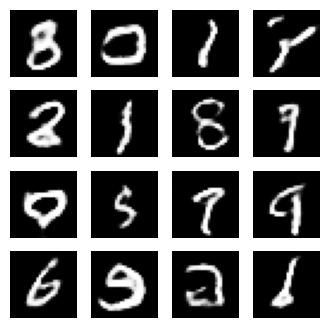

In [17]:
start_epoch = load_latest_checkpoint(checkpoint_dir, generator, discriminator, generator_optimizer, discriminator_optimizer)

# Make sure to call the train function correctly
train(train_loader, EPOCHS, generator, discriminator, generator_optimizer, discriminator_optimizer)

## Create a GIF

In [20]:
import PIL

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

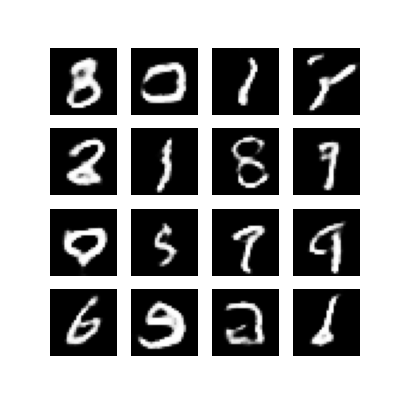

In [21]:
display_image(EPOCHS)

In [24]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\Devra\AppData\Local\Temp\ipykernel_19892\1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Devra\AppData\Local\Temp\ipykernel_19892\1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [25]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'